In [31]:
import sys
import os
from typing import Dict
import json
from tqdm import tqdm
from pathlib import Path
import numpy as np
from omegaconf import OmegaConf
import torch
import torch.nn.functional as F
import wandb
from types import SimpleNamespace
from vbll.layers.regression import VBLLReturn

from scipy.stats import pointbiserialr
from sklearn.metrics import roc_auc_score, average_precision_score

base_path = os.path.abspath(os.path.join('../..'))
sys.path.append(base_path)

from src.utils.data_utils import DatasetConfig
from src.data_loaders import get_queries, get_qrels
from src.utils.model_utils import vbll_model_factory, model_factory

In [2]:
def save_queries(data: list, data_dir: Path, split: str) -> None:
    """Save queries to file."""
    with open(data_dir / f'queries-{split}.jsonl', 'wt', encoding='utf8') as f_out:
        for query_data in tqdm(data, desc=f"Saving {split} queries"):
            json.dump({"query": query_data["query"], "OOD": query_data["OOD"]}, f_out)
            f_out.write("\n")

In [3]:
def prepare_test_queries(test_queries: list, queries: Dict, data_cfg: DatasetConfig, num_samples: int, OOD: bool) -> None:
    """Prepare test queries dataset."""
    qrels = get_qrels(data_cfg.get_qrels_file(split=data_cfg.test_name))
    
    i = 0
    for qid, rels in qrels.items():
        if len(rels) > 0:
            test_queries.append({"query": queries[qid], "OOD": OOD})
            i += 1
        
        if i >= num_samples: break
    
    return test_queries

In [4]:
msmarco_cfg = DatasetConfig('msmarco')
nq_cfg = DatasetConfig('nq')
hotpotqa_cfg = DatasetConfig('hotpotqa')
fiqa_cfg = DatasetConfig('fiqa')

In [5]:
msmarco_queries = get_queries(msmarco_cfg.get_queries_file())
nq_queries = get_queries(nq_cfg.get_queries_file())
hotpotqa_queries = get_queries(hotpotqa_cfg.get_queries_file())
fiqa_queries = get_queries(fiqa_cfg.get_queries_file())

In [7]:
run_id = "10nfecme"
args = OmegaConf.load(f'{base_path}/config.yml')
api = wandb.Api()
config = api.run(f"{args.wandb.entity}/{args.wandb.project}/{run_id}").config
params = SimpleNamespace(**config)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = f"{base_path}/output/models/{run_id}"
model_path = f"{save_dir}/model.pt"

tokenizer, model = vbll_model_factory(params.model_name, device)
method = "vbll"

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f'Loaded model from {model_path}')

/Users/oliverneut/miniconda3/envs/bret/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded model from /Users/oliverneut/Desktop/vbll-retrieval/output/models/10nfecme/model.pt


In [9]:
def infer_query(qry: str, tokenizer, model):
    qry_enc = tokenizer(qry, padding="max_length", truncation=True, max_length=32, return_tensors="pt")
    qry_emb = model(qry_enc)
    return qry_emb

def uncertainty_score(qry_emb, unc_method="norm"):
    cov = qry_emb.covariance.squeeze()

    if unc_method == "norm":
        return torch.sqrt(qry_emb.trace_covariance)
    elif unc_method == "trace":
        return qry_emb.trace_covariance
    elif unc_method == "det":
        return qry_emb.logdet_covariance
    elif unc_method == "entropy":
        d = cov.size(0)
        logdet = qry_emb.logdet_covariance
        return 0.5 * d * torch.log(torch.tensor(2 * torch.pi * torch.e)) + 0.5 * logdet
    else:
        raise ValueError(f"Unknown uncertainty method: {unc_method}")

In [10]:
def calculate_uncertainty_scores(data, tokenizer, model, unc_method="norm"):
    uncertainty_scores = []
    labels = []
    for query_data in tqdm(data, desc="Calculating uncertainty scores"):       
        emb = infer_query(query_data['query'], tokenizer, model)

        uncertainty_scores.append(uncertainty_score(emb.predictive, unc_method).item())
        labels.append(query_data['OOD'])

    return np.array(uncertainty_scores), np.array(labels)

In [11]:
def msp_score(logits):
    probs = F.softmax(logits, dim=-1)
    return 1 - probs.max(dim=-1).values

def entropy_score(logits):
    probs = F.softmax(logits, dim=-1)
    log_probs = torch.log(probs + 1e-12)
    return -(probs * log_probs).sum(dim=-1)

def energy_score(logits, temperature=1.0):
    return -temperature * torch.logsumexp(logits / temperature, dim=-1)

def calculate_baseline_scores(data, tokenizer, model):
    msp_scores = []
    entropy_scores = []
    energy_scores = []

    labels = []

    for query_data in tqdm(data, desc="Calculating uncertainty scores"):  
        emb = infer_query(query_data['query'], tokenizer, model)
        if isinstance(emb, VBLLReturn):
            emb = emb.predictive.loc
        msp_scores.append(msp_score(emb).item())
        entropy_scores.append(entropy_score(emb).item())
        energy_scores.append(energy_score(emb).item())
        
        labels.append(query_data['OOD'])

    return np.array(msp_scores), np.array(entropy_scores), np.array(energy_scores), np.array(labels)

In [12]:
def metrics(uncertainty_scores, labels):
    auc = roc_auc_score(labels, uncertainty_scores)
    print(f"AUROC: {auc}")
    aupr = average_precision_score(labels, uncertainty_scores)
    print(f"AUPR: {aupr}")
    pbs = pointbiserialr(labels, uncertainty_scores)
    print(f"Point Biserial Correlation: {pbs.correlation}, p-value: {pbs.pvalue}")

In [14]:
msmarco_nq_queries = []
msmarco_nq_queries = prepare_test_queries(msmarco_nq_queries, msmarco_queries, msmarco_cfg, 1000, OOD=False)
msmarco_nq_queries = prepare_test_queries(msmarco_nq_queries, nq_queries, nq_cfg, 1000, OOD=True)

In [15]:
unc_method = "norm"
uncertainty_scores, labels = calculate_uncertainty_scores(msmarco_nq_queries, tokenizer, model, unc_method="norm")
print(f"Uncertainty scores calculated using method {unc_method}")
metrics(uncertainty_scores, labels)
print('')

msp_scores, entropy_scores, energy_scores, labels = calculate_baseline_scores(msmarco_nq_queries, tokenizer, model)
print(f"Baseline scores calculated")
metrics(msp_scores, labels)
metrics(entropy_scores, labels)
metrics(energy_scores, labels)

Calculating uncertainty scores: 100%|██████████| 2000/2000 [00:44<00:00, 44.89it/s]


Uncertainty scores calculated using method norm
AUROC: 0.47761050000000005
AUPR: 0.48273771023740375
Point Biserial Correlation: -0.04650204584722596, p-value: 0.0375751365606453



Calculating uncertainty scores: 100%|██████████| 2000/2000 [00:44<00:00, 45.15it/s]

Baseline scores calculated
AUROC: 0.525672
AUPR: 0.5151179952637311
Point Biserial Correlation: 0.02809978149238754, p-value: 0.20907144432141286
AUROC: 0.523807
AUPR: 0.5211572527710577
Point Biserial Correlation: 0.0407419799981015, p-value: 0.0685075050534339
AUROC: 0.531596
AUPR: 0.5335598105542054
Point Biserial Correlation: 0.0602108317727549, p-value: 0.007071235899221918


In [16]:
msmarco_hotpotqa_queries = []
msmarco_hotpotqa_queries = prepare_test_queries(msmarco_hotpotqa_queries, msmarco_queries, msmarco_cfg, 1000, OOD=False)
msmarco_hotpotqa_queries = prepare_test_queries(msmarco_hotpotqa_queries, hotpotqa_queries, hotpotqa_cfg, 1000, OOD=True)

In [17]:
unc_method = "norm"
uncertainty_scores, labels = calculate_uncertainty_scores(msmarco_hotpotqa_queries, tokenizer, model, unc_method=unc_method)
print(f"Uncertainty scores calculated using method {unc_method}")
metrics(uncertainty_scores, labels)
print('')

msp_scores, entropy_scores, energy_scores, labels = calculate_baseline_scores(msmarco_hotpotqa_queries, tokenizer, model)
print(f"Baseline scores calculated")
metrics(msp_scores, labels)
metrics(entropy_scores, labels)
metrics(energy_scores, labels)

Calculating uncertainty scores: 100%|██████████| 2000/2000 [00:43<00:00, 45.98it/s]


Uncertainty scores calculated using method norm
AUROC: 0.08227199999999998
AUPR: 0.3238643132527613
Point Biserial Correlation: -0.7061367607382435, p-value: 7.268151566712335e-302



Calculating uncertainty scores: 100%|██████████| 2000/2000 [00:44<00:00, 45.11it/s]

Baseline scores calculated
AUROC: 0.528875
AUPR: 0.49732584303801497
Point Biserial Correlation: -0.017223619734340057, p-value: 0.44139526048974737
AUROC: 0.538689
AUPR: 0.5072515442807781
Point Biserial Correlation: 0.0336054746041069, p-value: 0.13300228567433267
AUROC: 0.6045195
AUPR: 0.5621183791642528
Point Biserial Correlation: 0.19973672571349443, p-value: 1.9167873718608717e-19


In [ ]:
msmarco_fiqa_queries = []
msmarco_fiqa_queries = prepare_test_queries(msmarco_fiqa_queries, msmarco_queries, msmarco_cfg, 1000, OOD=False)
msmarco_fiqa_queries = prepare_test_queries(msmarco_fiqa_queries, fiqa_queries, fiqa_cfg, 1000, OOD=True)

In [19]:
uncertainty_scores, labels = calculate_uncertainty_scores(msmarco_fiqa_queries, tokenizer, model, unc_method="norm")
print(f"Uncertainty scores calculated using method {unc_method}")
metrics(uncertainty_scores, labels)
print('')

msp_scores, entropy_scores, energy_scores, labels = calculate_baseline_scores(msmarco_fiqa_queries, tokenizer, model)
print(f"Baseline scores calculated")
metrics(msp_scores, labels)
metrics(entropy_scores, labels)
metrics(energy_scores, labels)

Calculating uncertainty scores: 100%|██████████| 1500/1500 [00:34<00:00, 43.93it/s]


Uncertainty scores calculated using method norm
AUROC: 0.67563
AUPR: 0.7783423089014669
Point Biserial Correlation: 0.3218775548937509, p-value: 1.6825287642309795e-37



Calculating uncertainty scores: 100%|██████████| 1500/1500 [00:33<00:00, 44.77it/s]

Baseline scores calculated
AUROC: 0.547342
AUPR: 0.7398583176287041
Point Biserial Correlation: 0.14415916727951011, p-value: 2.0477022593974783e-08
AUROC: 0.540356
AUPR: 0.7366394437197772
Point Biserial Correlation: 0.11477959523501863, p-value: 8.333814981161278e-06
AUROC: 0.5137849999999999
AUPR: 0.719545840216764
Point Biserial Correlation: 0.008305829425592725, p-value: 0.7478915514013337


In [20]:
run_id = "yi84sy0n"
args = OmegaConf.load(f'{base_path}/config.yml')
api = wandb.Api()
config = api.run(f"{args.wandb.entity}/{args.wandb.project}/{run_id}").config
params = SimpleNamespace(**config)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = f"{base_path}/output/models/{run_id}"
model_path = f"{save_dir}/model.pt"

tokenizer, model = model_factory(params.model_name, device)
method = "vbll"

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f'Loaded model from {model_path}')

/Users/oliverneut/miniconda3/envs/bret/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded model from /Users/oliverneut/Desktop/vbll-retrieval/output/models/yi84sy0n/model.pt


In [22]:
msmarco_nq_queries = []
msmarco_nq_queries = prepare_test_queries(msmarco_nq_queries, msmarco_queries, msmarco_cfg, 1000, OOD=False)
msmarco_nq_queries = prepare_test_queries(msmarco_nq_queries, nq_queries, nq_cfg, 1000, OOD=True)

msp_scores, entropy_scores, energy_scores, labels = calculate_baseline_scores(msmarco_nq_queries, tokenizer, model)
print(f"Baseline scores calculated")
metrics(msp_scores, labels)
metrics(entropy_scores, labels)
metrics(energy_scores, labels)

Calculating uncertainty scores: 100%|██████████| 2000/2000 [00:38<00:00, 52.51it/s]


Baseline scores calculated
AUROC: 0.3251635
AUPR: 0.3870879685132027
Point Biserial Correlation: -0.2912875530984401, p-value: 2.0724625916697796e-40
AUROC: 0.2975735
AUPR: 0.3746156848346671
Point Biserial Correlation: -0.3562519724269746, p-value: 6.510096012965339e-61
AUROC: 0.308416
AUPR: 0.37922080807658354
Point Biserial Correlation: -0.3391698477462174, p-value: 4.990034077487274e-55


In [23]:
msmarco_hotpotqa_queries = []
msmarco_hotpotqa_queries = prepare_test_queries(msmarco_hotpotqa_queries, msmarco_queries, msmarco_cfg, 1000, OOD=False)
msmarco_hotpotqa_queries = prepare_test_queries(msmarco_hotpotqa_queries, hotpotqa_queries, hotpotqa_cfg, 1000, OOD=True)

msp_scores, entropy_scores, energy_scores, labels = calculate_baseline_scores(msmarco_hotpotqa_queries, tokenizer, model)
print(f"Baseline scores calculated")
metrics(msp_scores, labels)
metrics(entropy_scores, labels)
metrics(energy_scores, labels)

Calculating uncertainty scores: 100%|██████████| 2000/2000 [00:40<00:00, 49.28it/s]

Baseline scores calculated
AUROC: 0.17428500000000002
AUPR: 0.33581042164270286
Point Biserial Correlation: -0.5290336783813766, p-value: 1.1941099073968296e-144
AUROC: 0.05588950000000001
AUPR: 0.3131043782951018
Point Biserial Correlation: -0.7469927658654278, p-value: 0.0
AUROC: 0.0627865
AUPR: 0.31388121609946895
Point Biserial Correlation: -0.7342374998637424, p-value: 0.0


In [25]:
msmarco_fiqa_queries = []
msmarco_fiqa_queries = prepare_test_queries(msmarco_fiqa_queries, msmarco_queries, msmarco_cfg, 1000, OOD=False)
msmarco_fiqa_queries = prepare_test_queries(msmarco_fiqa_queries, fiqa_queries, fiqa_cfg, 1000, OOD=True)

msp_scores, entropy_scores, energy_scores, labels = calculate_baseline_scores(msmarco_fiqa_queries, tokenizer, model)
print(f"Baseline scores calculated")
metrics(msp_scores, labels)
metrics(entropy_scores, labels)
metrics(energy_scores, labels)

Calculating uncertainty scores:   0%|          | 0/1500 [00:00<?, ?it/s]

Calculating uncertainty scores: 100%|██████████| 1500/1500 [00:34<00:00, 43.35it/s]


Baseline scores calculated
AUROC: 0.322836
AUPR: 0.24314550845275426
Point Biserial Correlation: -0.28614438280964427, p-value: 1.165515795727049e-29
AUROC: 0.187816
AUPR: 0.2101922457131668
Point Biserial Correlation: -0.5071649098866916, p-value: 7.657117787132468e-99
AUROC: 0.20453000000000002
AUPR: 0.21340164975690346
Point Biserial Correlation: -0.48145016550341263, p-value: 7.133268741670028e-88


In [34]:
import matplotlib.pyplot as plt
import numpy as np
args = OmegaConf.load('../colors.yml')

In [41]:
colors = {
    "MSP": args.red.mid,
    "entropy": args.blue.mid,
    "energy": args.green.mid,
    "norm": args.purple.mid
}

edge_colors = {
    "MSP": args.red.dark,
    "entropy": args.blue.dark,
    "energy": args.green.dark,
    "norm": args.purple.dark
}

In [80]:
colors = {
    "MSP": "#C44552",
    "entropy": "#565C8A",
    "energy": "#5CAD73",
    "norm": "#856247"
}

edge_colors = {
    "MSP": "#6D222A",
    "entropy": "#2A2D43",
    "energy": "#376D46",
    "norm": "#513C2C"
}

In [112]:
colors = {
    "MSP": "#3C6255",
    "entropy": "#61876E",
    "energy": "#A6BB8D",
    "norm": "#EAE7B1"
}

edge_colors = {
    "MSP": "#273F37",
    "entropy": "#273F37",
    "energy": "#273F37",
    "norm": "#273F37"
}

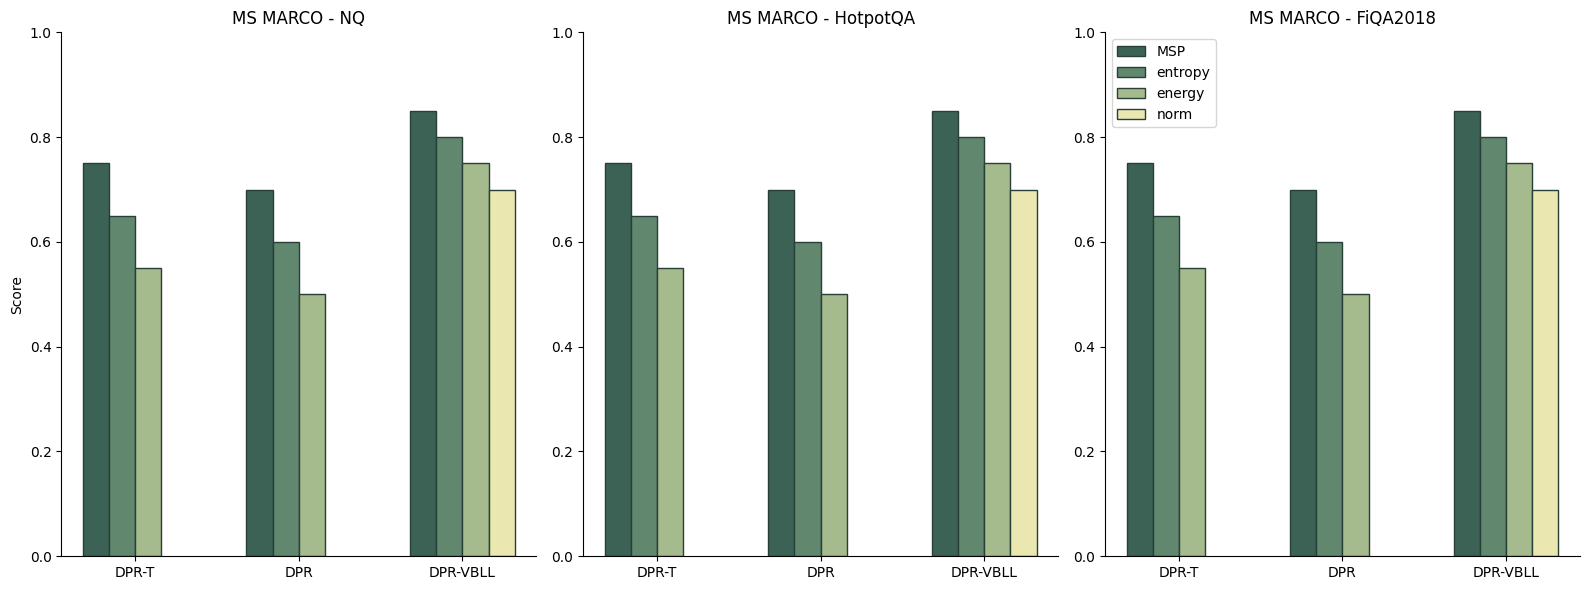

In [114]:
models = ['DPR-T', 'DPR', 'DPR-VBLL']
methods = ['MSP', 'entropy', 'energy', 'norm']

scores = np.array([
    [0.75, 0.65, 0.55, np.nan],# DPR-T (only 3 methods)
    [0.7, 0.6, 0.5, np.nan],   # DPR (only 3 methods)
    [0.85, 0.8, 0.75, 0.7],    # DPR-VBLL (4 methods)
])

n_models = len(models)
n_methods = len(methods)
bar_width = 0.16
x = np.arange(n_models)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, method in enumerate(methods):
    # Offset each method's bars
    offsets = (i - (n_methods-1)/2) * bar_width
    # Only plot bars where score is not nan
    valid = ~np.isnan(scores[:, i])
    axes[0].bar(x[valid] + offsets, scores[valid, i], width=bar_width, label=method, color=colors[method], edgecolor=edge_colors[method], linewidth=1)

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylim(0, 1)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel('Score')
# axes[0].grid(True, axis='y', ls='--')
axes[0].set_title('MS MARCO - NQ')


scores = np.array([
    [0.75, 0.65, 0.55, np.nan],# DPR-T (only 3 methods)
    [0.7, 0.6, 0.5, np.nan],   # DPR (only 3 methods)
    [0.85, 0.8, 0.75, 0.7],    # DPR-VBLL (4 methods)
])

for i, method in enumerate(methods):
    # Offset each method's bars
    offsets = (i - (n_methods-1)/2) * bar_width
    # Only plot bars where score is not nan
    valid = ~np.isnan(scores[:, i])
    axes[1].bar(x[valid] + offsets, scores[valid, i], width=bar_width, label=method, color=colors[method], edgecolor=edge_colors[method], linewidth=1)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_ylim(0, 1)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
# axes[1].grid(True, axis='y', ls='--')
axes[1].set_title('MS MARCO - HotpotQA')


scores = np.array([
    [0.75, 0.65, 0.55, np.nan],# DPR-T (only 3 methods)
    [0.7, 0.6, 0.5, np.nan],   # DPR (only 3 methods)
    [0.85, 0.8, 0.75, 0.7],    # DPR-VBLL (4 methods)
])

for i, method in enumerate(methods):
    # Offset each method's bars
    offsets = (i - (n_methods-1)/2) * bar_width
    # Only plot bars where score is not nan
    valid = ~np.isnan(scores[:, i])
    axes[2].bar(x[valid] + offsets, scores[valid, i], width=bar_width, label=method, color=colors[method], edgecolor=edge_colors[method], linewidth=1)

axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_ylim(0, 1)
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].set_title('MS MARCO - FiQA2018')
# axes[2].grid(True, axis='y', ls='--')
axes[2].legend()
plt.tight_layout()
plt.show()
fig.savefig(f"../figures/ood/ood-3.png", bbox_inches='tight', dpi=300)